In [3]:
data_root = (r"C:\Users\91702\Desktop\Download Images\images")

In [1]:
import tensorflow as tf
import numpy as np

In [4]:
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)

datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="validation", 
    shuffle=True,
    target_size=IMAGE_SHAPE
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="training", 
    shuffle=True,
    target_size=IMAGE_SHAPE)

Found 390 images belonging to 18 classes.
Found 1597 images belonging to 18 classes.


In [5]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((32, 224, 224, 3), (32, 18))

In [6]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'ripe apple': 0, 'ripe banana': 1, 'ripe mango': 2, 'ripe orange': 3, 'ripe papaya': 4, 'ripe pomegranate': 5, 'rotten apple': 6, 'rotten banana': 7, 'rotten mango': 8, 'rotten orange': 9, 'rotten papaya': 10, 'rotten pomegranate': 11, 'unripe apple': 12, 'unripe banana': 13, 'unripe mango': 14, 'unripe orange': 15, 'unripe papaya': 16, 'unripe pomegranate': 17}


In [7]:
!cat labels.txt

'cat' is not recognized as an internal or external command,
operable program or batch file.


In [8]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# create the base pre-trained model
base_model = MobileNetV2(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(18, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])

9420800/9406464 [==============================] - 12s 1us/step


In [9]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

hist = model.fit(train_generator, epochs=5, verbose=1,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=valid_generator,
                    validation_steps=val_steps_per_epoch).history

Epoch 1/5
50/50 [==============================] - 36s 683ms/step - loss: 1.5303 - accuracy: 0.5698 - val_loss: 0.9594 - val_accuracy: 0.7769
Epoch 2/5
50/50 [==============================] - 24s 478ms/step - loss: 0.4899 - accuracy: 0.8572 - val_loss: 0.8287 - val_accuracy: 0.7744
Epoch 3/5
50/50 [==============================] - 24s 473ms/step - loss: 0.2518 - accuracy: 0.9186 - val_loss: 0.5447 - val_accuracy: 0.8974
Epoch 4/5
50/50 [==============================] - 24s 475ms/step - loss: 0.1516 - accuracy: 0.9530 - val_loss: 0.5421 - val_accuracy: 0.8692
Epoch 5/5
50/50 [==============================] - 24s 475ms/step - loss: 0.1033 - accuracy: 0.9693 - val_loss: 0.5717 - val_accuracy: 0.8692


In [10]:
 for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_1
1 Conv1
2 bn_Conv1
3 Conv1_relu
4 expanded_conv_depthwise
5 expanded_conv_depthwise_BN
6 expanded_conv_depthwise_relu
7 expanded_conv_project
8 expanded_conv_project_BN
9 block_1_expand
10 block_1_expand_BN
11 block_1_expand_relu
12 block_1_pad
13 block_1_depthwise
14 block_1_depthwise_BN
15 block_1_depthwise_relu
16 block_1_project
17 block_1_project_BN
18 block_2_expand
19 block_2_expand_BN
20 block_2_expand_relu
21 block_2_depthwise
22 block_2_depthwise_BN
23 block_2_depthwise_relu
24 block_2_project
25 block_2_project_BN
26 block_2_add
27 block_3_expand
28 block_3_expand_BN
29 block_3_expand_relu
30 block_3_pad
31 block_3_depthwise
32 block_3_depthwise_BN
33 block_3_depthwise_relu
34 block_3_project
35 block_3_project_BN
36 block_4_expand
37 block_4_expand_BN
38 block_4_expand_relu
39 block_4_depthwise
40 block_4_depthwise_BN
41 block_4_depthwise_relu
42 block_4_project
43 block_4_project_BN
44 block_4_add
45 block_5_expand
46 block_5_expand_BN
47 block_5_expand_relu
48 b

In [11]:
for layer in model.layers[:125]:
   layer.trainable = False
for layer in model.layers[125:]:
   layer.trainable = True

In [12]:
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\91702\anaconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [13]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

hist = model.fit(train_generator, epochs=5, verbose=1,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=valid_generator,
                    validation_steps=val_steps_per_epoch).history

Epoch 1/5
50/50 [==============================] - 29s 556ms/step - loss: 0.4646 - accuracy: 0.8472 - val_loss: 0.5798 - val_accuracy: 0.8769
Epoch 2/5
50/50 [==============================] - 28s 552ms/step - loss: 0.1869 - accuracy: 0.9405 - val_loss: 0.5888 - val_accuracy: 0.8744
Epoch 3/5
50/50 [==============================] - 27s 549ms/step - loss: 0.1361 - accuracy: 0.9574 - val_loss: 0.5870 - val_accuracy: 0.8718
Epoch 4/5
50/50 [==============================] - 27s 544ms/step - loss: 0.0964 - accuracy: 0.9756 - val_loss: 0.5755 - val_accuracy: 0.8667
Epoch 5/5
50/50 [==============================] - 27s 550ms/step - loss: 0.0818 - accuracy: 0.9806 - val_loss: 0.5612 - val_accuracy: 0.8718


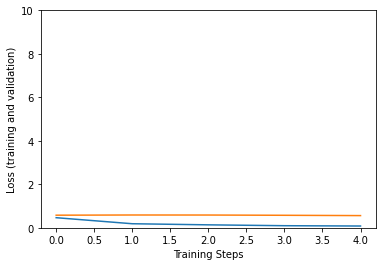

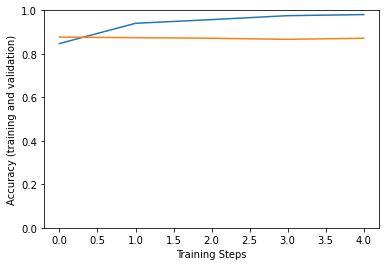

In [14]:
import matplotlib.pyplot as plt

plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,10])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

In [15]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [24]:
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Ripe Apple' 'Ripe Banana' 'Ripe Mango' 'Ripe Orange' 'Ripe Papaya'
 'Ripe Pomegranate' 'Rotten Apple' 'Rotten Banana' 'Rotten Mango'
 'Rotten Orange' 'Rotten Papaya' 'Rotten Pomegranate' 'Unripe Apple'
 'Unripe Banana' 'Unripe Mango' 'Unripe Orange' 'Unripe Papaya'
 'Unripe Pomegranate']


In [17]:
tf_model_predictions = model.predict(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

Prediction results shape: (32, 18)


In [18]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
print(predicted_labels)

['Ripe Mango' 'Rotten Apple' 'Ripe Mango' 'Ripe Banana' 'Rotten Mango'
 'Unripe Papaya' 'Ripe Pomegranate' 'Ripe Apple' 'Unripe Orange'
 'Rotten Orange' 'Ripe Mango' 'Unripe Papaya' 'Ripe Apple' 'Rotten Apple'
 'Unripe Papaya' 'Unripe Orange' 'Ripe Banana' 'Rotten Pomegranate'
 'Ripe Banana' 'Ripe Apple' 'Rotten Mango' 'Rotten Banana' 'Unripe Orange'
 'Rotten Apple' 'Unripe Pomegranate' 'Unripe Orange' 'Ripe Papaya'
 'Ripe Banana' 'Unripe Papaya' 'Unripe Apple' 'Unripe Apple' 'Ripe Apple']


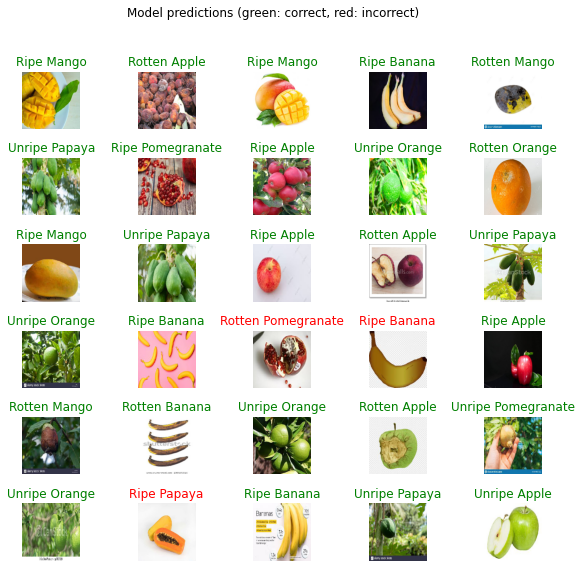

In [19]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range((len(predicted_labels)-2)):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [20]:
model.save('FR4model')

INFO:tensorflow:Assets written to: FR4model\assets


C:\Users\91702\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\91702\anaconda3\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [21]:
model.save('FR4model.h5')

In [29]:
dataset_labels = ['Ripe Apple', 'Ripe Banana', 'Ripe Mango', 'Ripe Orange', 'Ripe Papaya',
 'Ripe Pomegranate', 'Rotten Apple', 'Rotten Banana', 'Rotten Mango',
 'Rotten Orange', 'Rotten Papaya', 'Rotten Pomegranate', 'Unripe Apple',
 'Unripe Banana', 'Unripe Mango', 'Unripe Orange', 'Unripe Papaya',
 'Unripe Pomegranate']

img = image.load_img('C:/Users/91702/Desktop/download.jpg', target_size=(224,224))
#img = img / 255
x = image.img_to_array(img)
x = x / 255
x = np.expand_dims(x, axis=0)
#x = np.vstack([x])
result = model.predict(x)

result1 = result[0]
print(result1)
predicted_id = np.argmax(result1)
predicted_label = dataset_labels[predicted_id]
print(predicted_label)


[1.8378870e-07 1.9552714e-07 9.9999177e-01 1.6842052e-06 6.0170601e-06
 1.6168677e-08 1.7732077e-10 9.6143024e-11 7.3416637e-12 1.9069683e-08
 2.1570861e-11 1.8878914e-09 2.5758252e-08 8.3654433e-10 1.0941151e-08
 9.0241425e-10 7.9168672e-08 3.7746268e-08]
Ripe Mango
